# Capstone Project 
## Part 1 - Predicting Airbnb rental prices

## Exploratory Data Analysis - Dec 20 active listings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PowerTransformer

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

In [4]:
# load listings data
df = pd.read_csv('../../GA/capstone-data-airbnb/dec20-data/active_listings_clean.csv', index_col=0)
df.shape

(20994, 42)

In [5]:
# load sentiment analysis data
df_sa = pd.read_csv('../../GA/capstone-data-airbnb/dec20-data/reviews_sentiment_analysis_aggregated.csv', index_col=0)
df_sa.shape

(51836, 9)

In [6]:
# rename columns
df_sa.columns = ['sentiment_analysis_' + col for col in df_sa.columns]
df_sa.rename(columns={'sentiment_analysis_listing_id': 'id'}, inplace=True)
# merge sentiment analysis
df = pd.merge(df, df_sa, on='id', how='left')

In [7]:
# function to impute mean for missing values in sentiment analysis columns
def impute_mean(df, col):
    mean = df[col].mean()
    df[col].fillna(mean, inplace=True)

In [8]:
# impute missing values with mean
for col in ['sentiment_analysis_mean', 'sentiment_analysis_median',
            'sentiment_analysis_std', 'sentiment_analysis_skew',
            'sentiment_analysis_kurtosis', 'sentiment_analysis_count',
            'sentiment_analysis_max', 'sentiment_analysis_min']:
    impute_mean(df, col)

In [10]:
# load geographical data
df_geo = pd.read_csv('../../GA/capstone-data-airbnb/dec20-data/active_listings_geo_clean.csv', index_col=0)
df_geo.shape

(20994, 17)

In [11]:
df_geo.drop(columns=['price', 'neighbourhood_cleansed', 'longitude', 'latitude'], inplace=True)
# merge geographical data
df = pd.merge(df, df_geo, on='id', how='left')
df.shape

(20994, 62)

In [12]:
categorical = ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
               'neighbourhood_cleansed', 'room_type']

numerical = ['host_is_superhost', 'host_listings_count', 'host_identity_verified',
             'accommodates', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
             'availability_30', 'availability_60', 'availability_90', 'availability_365', 
             'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
             'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
             'review_scores_value', 'first_review_days', 'last_review_days', 'instant_bookable', 
             'reviews_per_month', 'number_bathrooms', 'private_bathroom', 'number_beds', 
             'number_bedrooms', 'host_since_days', 'sentiment_analysis_mean', 
             'sentiment_analysis_std', 'sentiment_analysis_skew', 'sentiment_analysis_kurtosis',  
             'British Museum', 'Tate Modern', 'National Gallery', 'Natural History Museum',
             'Southbank Centre', 'V&A Museum', 'Science Museum', 'Tower of London',
             'Royal Museums Greenwich', 'Somerset House', 'Kew Gardens', 'Tate Britain']

text = ['name', 'description', 'neighborhood_overview', 'property_type', 'amenities']

unused = ['id', 'host_name', 'sentiment_analysis_median', 'sentiment_analysis_count',
          'sentiment_analysis_max', 'sentiment_analysis_min']

len(categorical) + len(numerical) + len(text) + len(unused)

61

### Distribution of listing prices

In [13]:
df[['price']].describe()

price
count  20994.000000
mean     106.495461
std      106.865300
min        8.000000
25%       45.000000
50%       80.000000
75%      129.000000
max     2442.000000

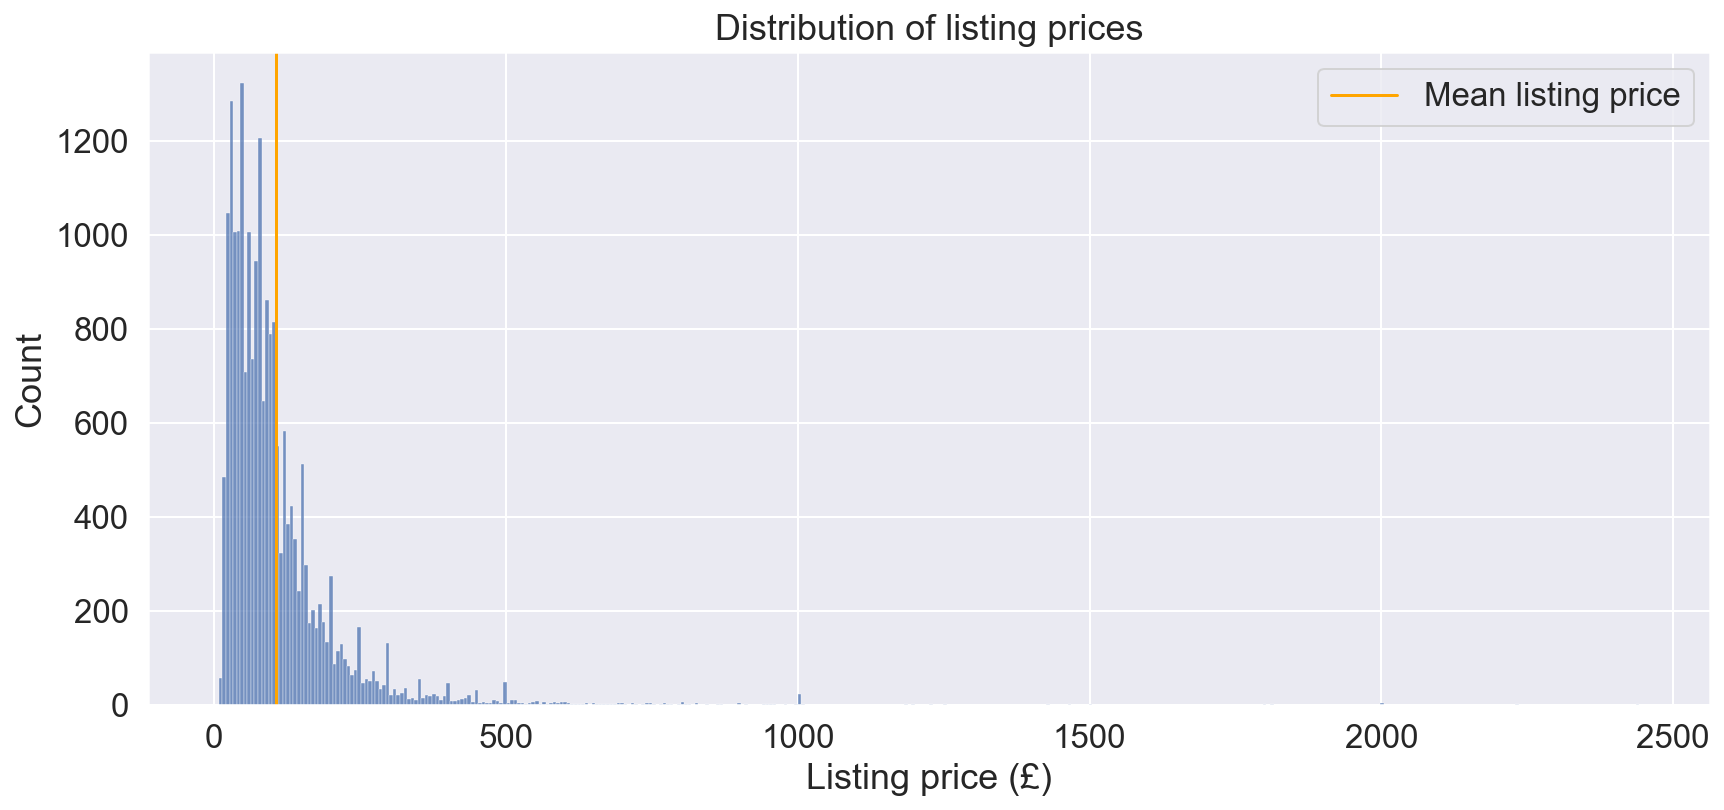

In [16]:
# plot listing price
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(df, x='price', ax=ax)
ax.axvline(x=df.price.mean(), color='orange', label='Mean')
ax.legend(['Mean listing price'])
ax.set_xlabel('Listing price (£)')
ax.set_ylabel('Count')
ax.set_title('Distribution of listing prices')
plt.show()

In [12]:
# look at power transformations and log transformation of price
pt_bc = PowerTransformer(method='box-cox')
pt_price_bc = pt_bc.fit_transform(np.array(df.price).reshape(-1, 1))
pt_price_bc = pd.Series(pt_price_bc.ravel())

pt_yj = PowerTransformer(method='yeo-johnson')
pt_price_yj = pt_yj.fit_transform(np.array(df.price).reshape(-1, 1))
pt_price_yj = pd.Series(pt_price_yj.ravel())

log_price = np.log(df.price)

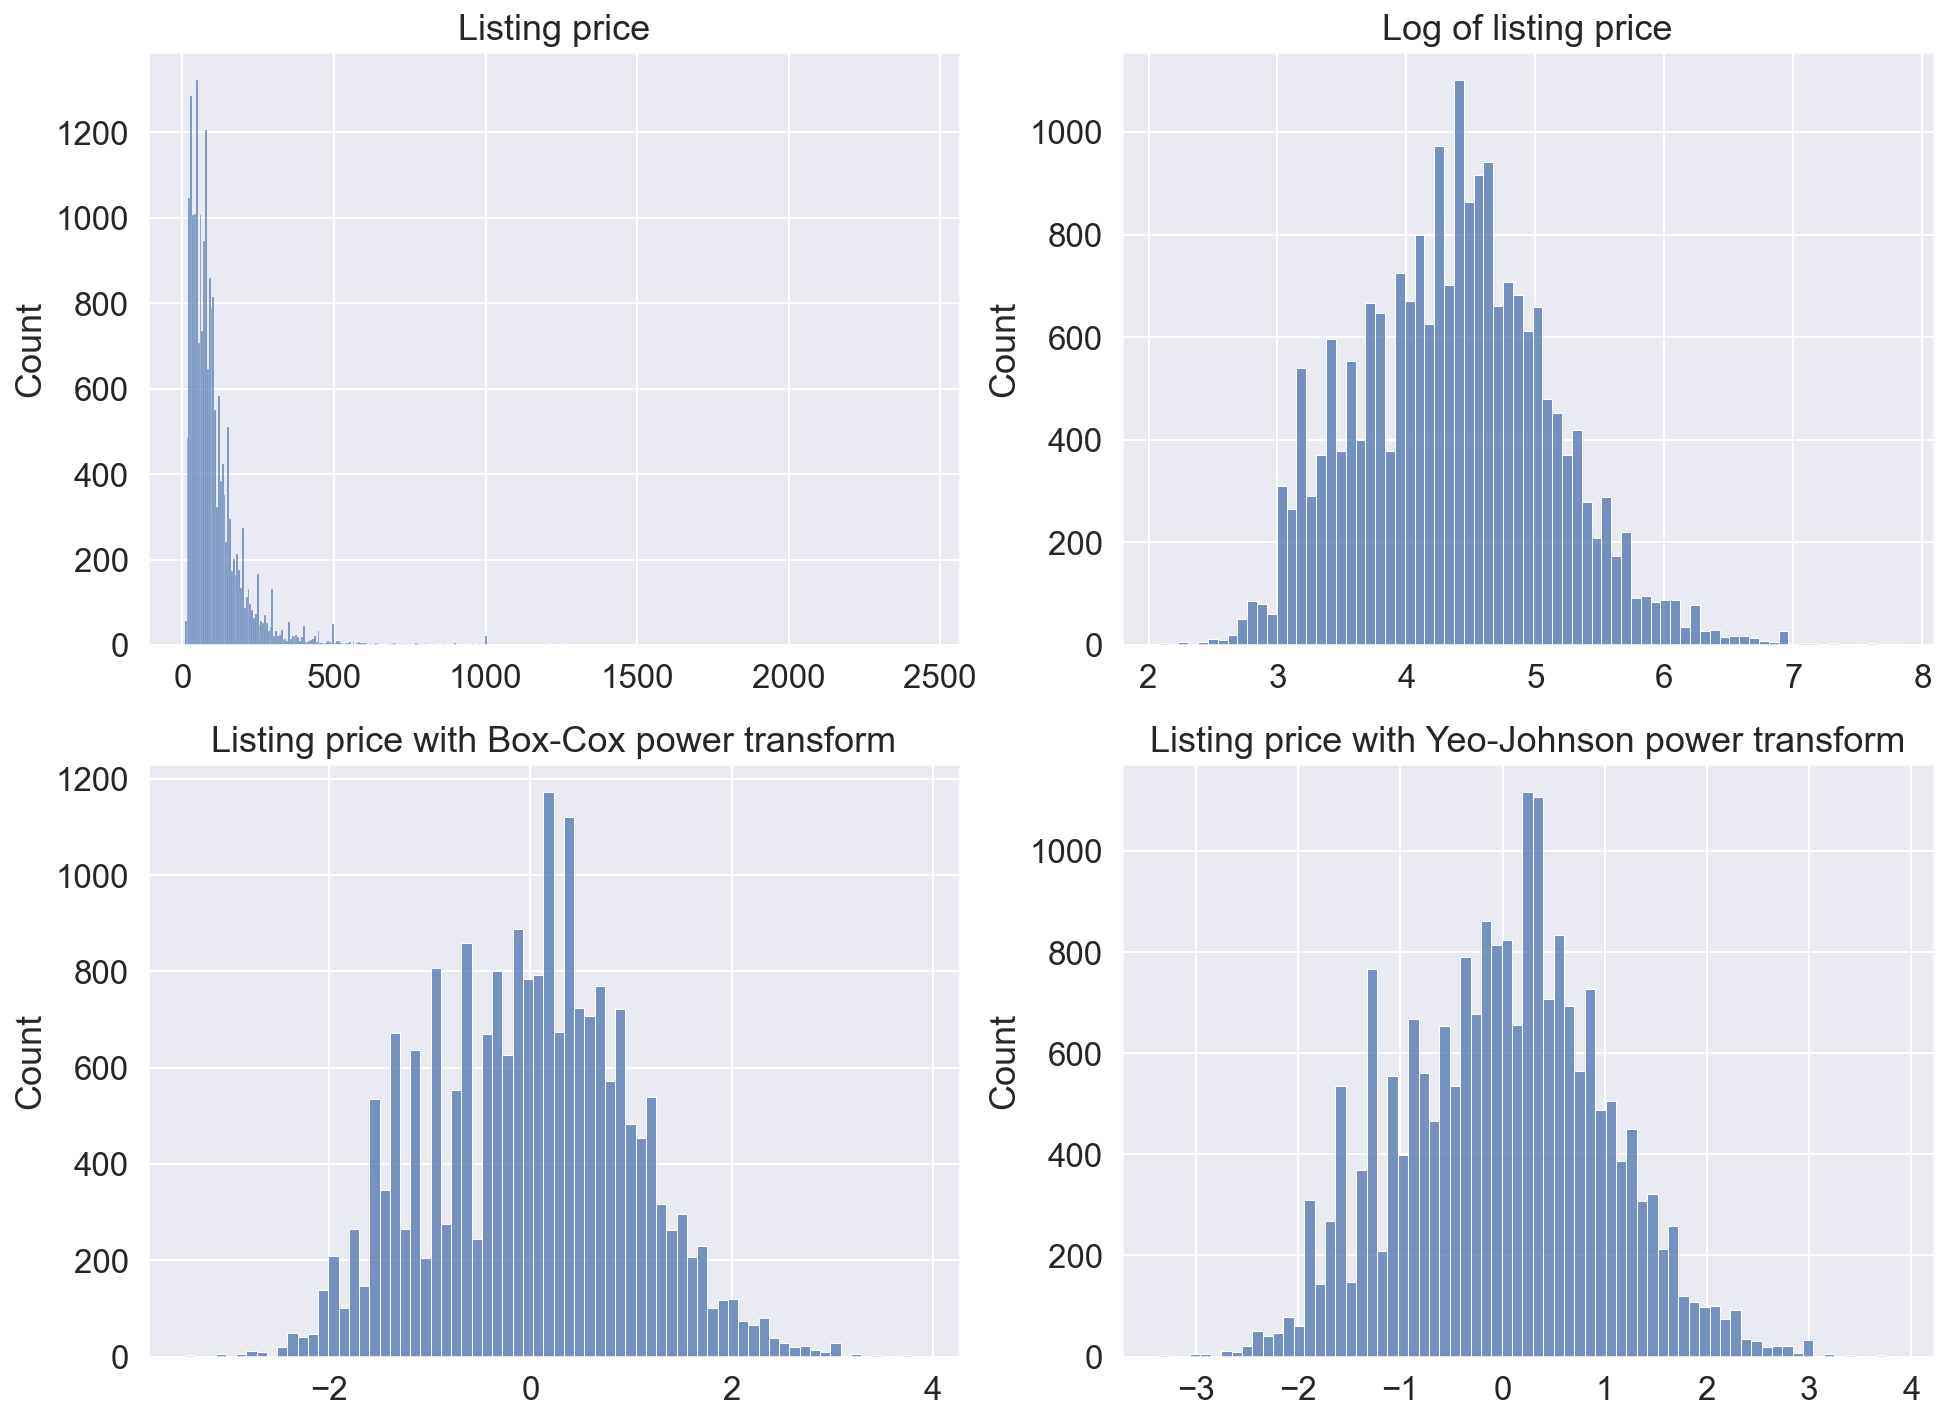

In [13]:
# compare histogram of price, log price and price after different power transformations
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
sns.histplot(df.price, ax=ax[0][0])
sns.histplot(log_price, ax=ax[0][1])
sns.histplot(pt_price_bc, ax=ax[1][0])
sns.histplot(pt_price_yj, ax=ax[1][1])

for a in ax:
    for z in a:
        z.set_xlabel(None)
        
ax[0][0].set_title('Listing price')
ax[0][1].set_title('Log of listing price')
ax[1][0].set_title('Listing price with Box-Cox power transform')
ax[1][1].set_title('Listing price with Yeo-Johnson power transform')

plt.show()

### Analysis of numerical variables

In [14]:
df_plot = df.copy()
df_plot['log_price'] = log_price
df_plot['adj_price'] = pt_price_bc

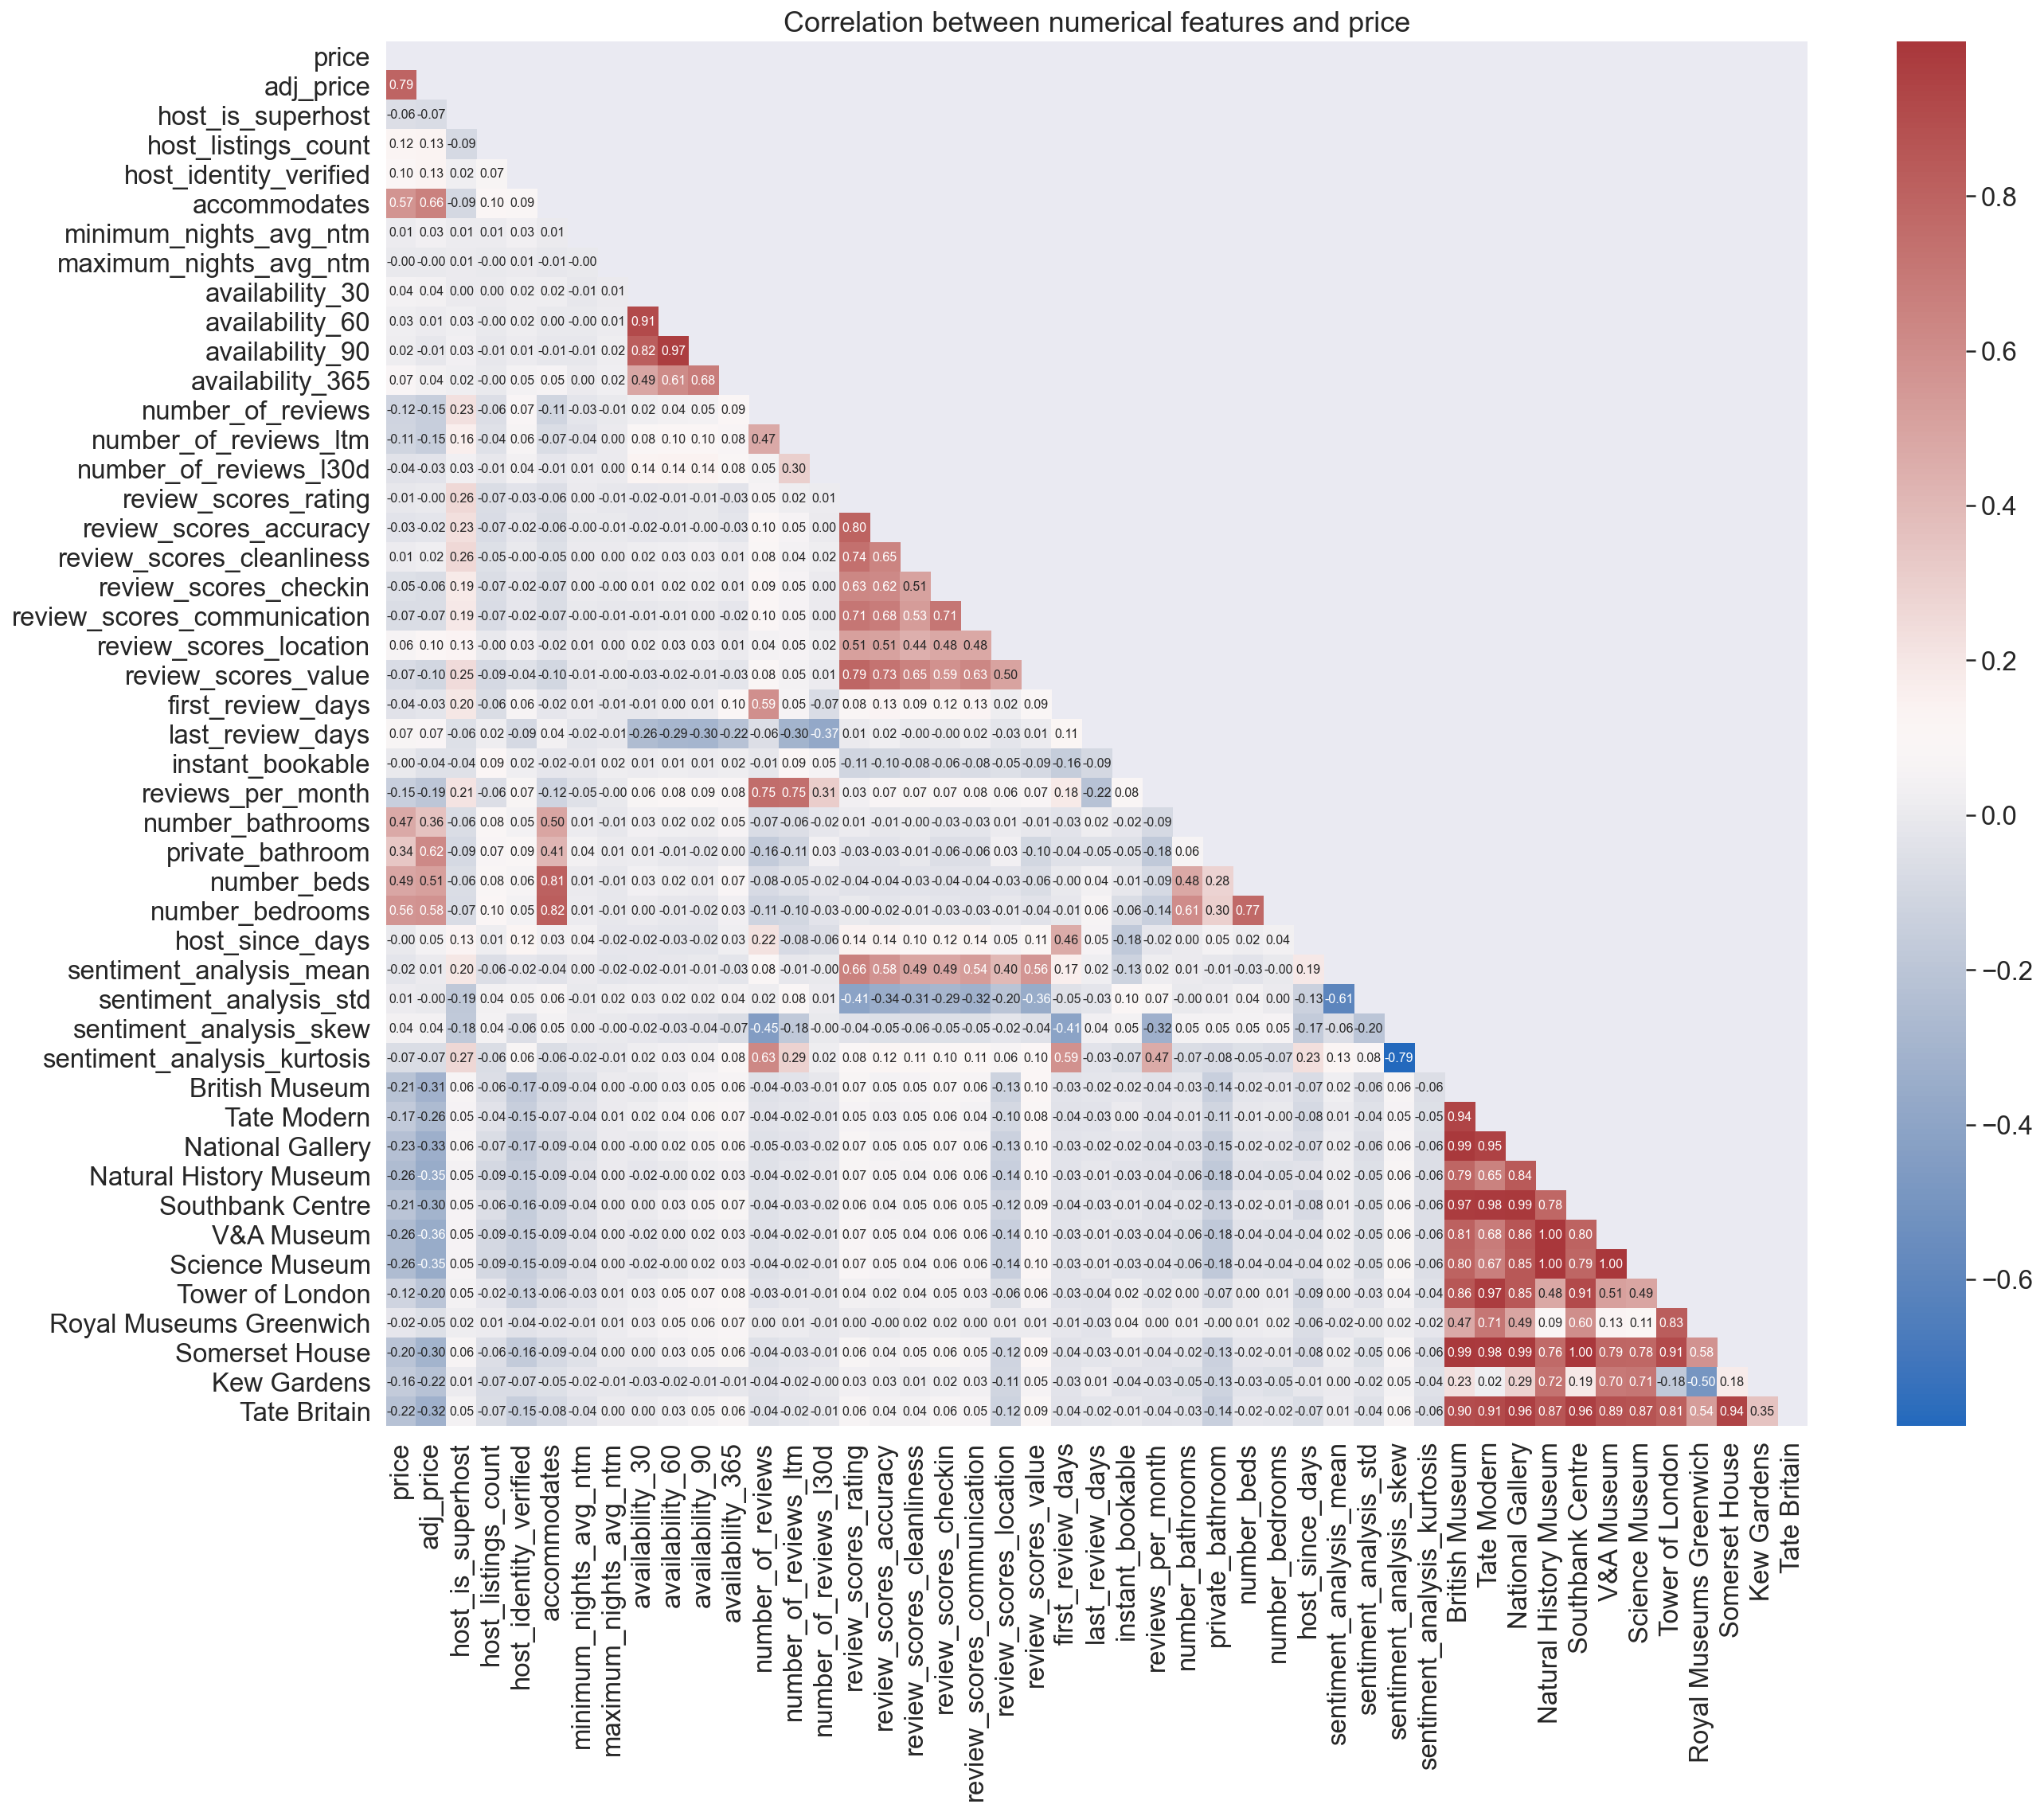

In [15]:
# calculate pairwise correlations between numerical features and price
corr = df_plot[['price', 'adj_price'] + numerical].corr()

fig, ax = plt.subplots(figsize=(20, 16))

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot the heatmap with seaborn
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', ax=ax, cmap='vlag')
ax.set_ylim([corr.shape[1], 0])

texts = ax.texts
for text in texts:
    text.set_size(8)
        
plt.title('Correlation between numerical features and price')
plt.show()

#### Pair plots

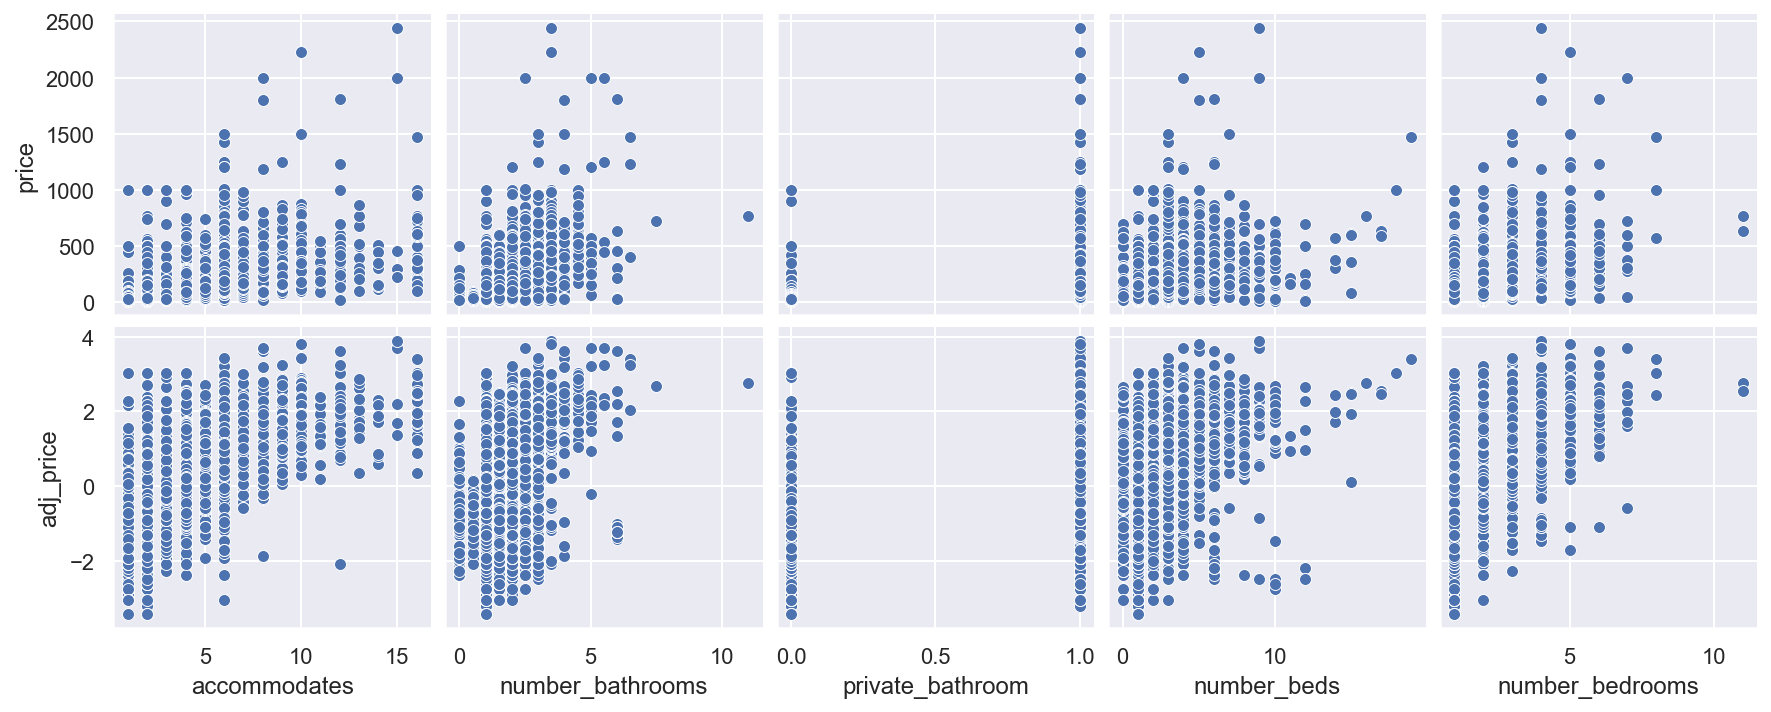

In [16]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1)
sns.pairplot(data=df_plot, x_vars=['accommodates', 'number_bathrooms', 'private_bathroom',
                                   'number_beds', 'number_bedrooms'], 
             y_vars=['price', 'adj_price'], diag_kind=None);

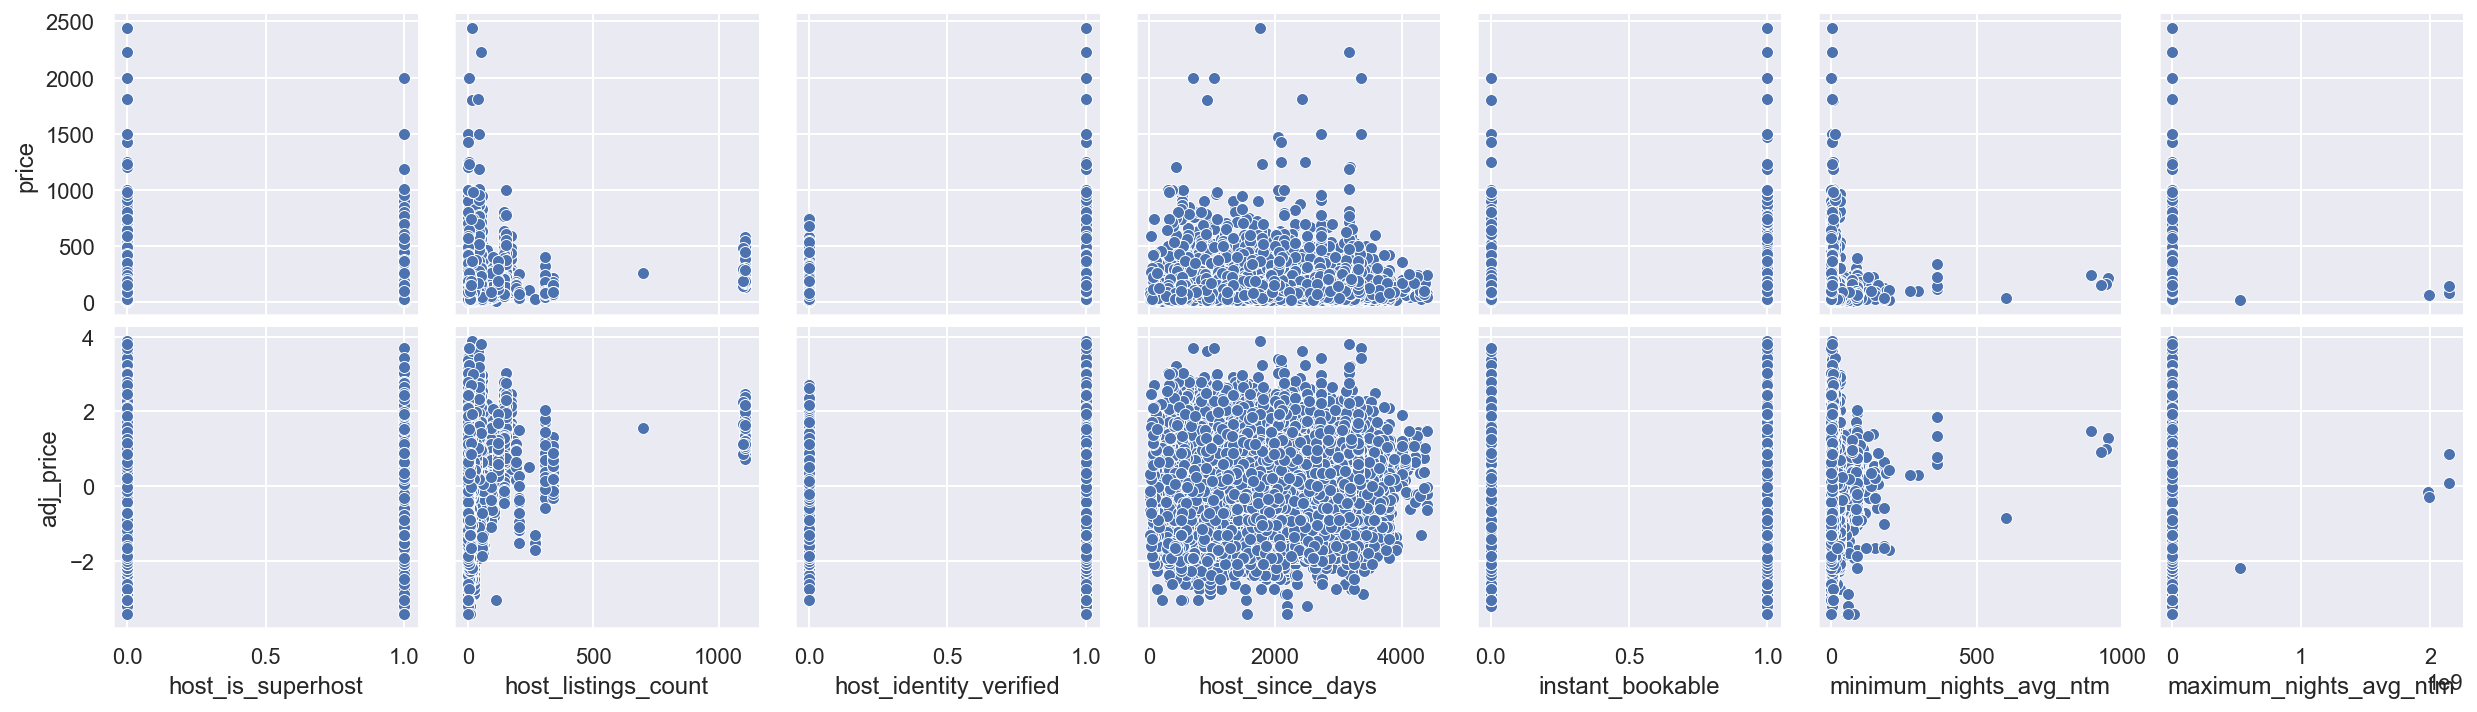

In [17]:
sns.pairplot(data=df_plot, x_vars=['host_is_superhost', 'host_listings_count', 'host_identity_verified',
                                   'host_since_days', 'instant_bookable', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], 
             y_vars=['price', 'adj_price'], diag_kind=None);

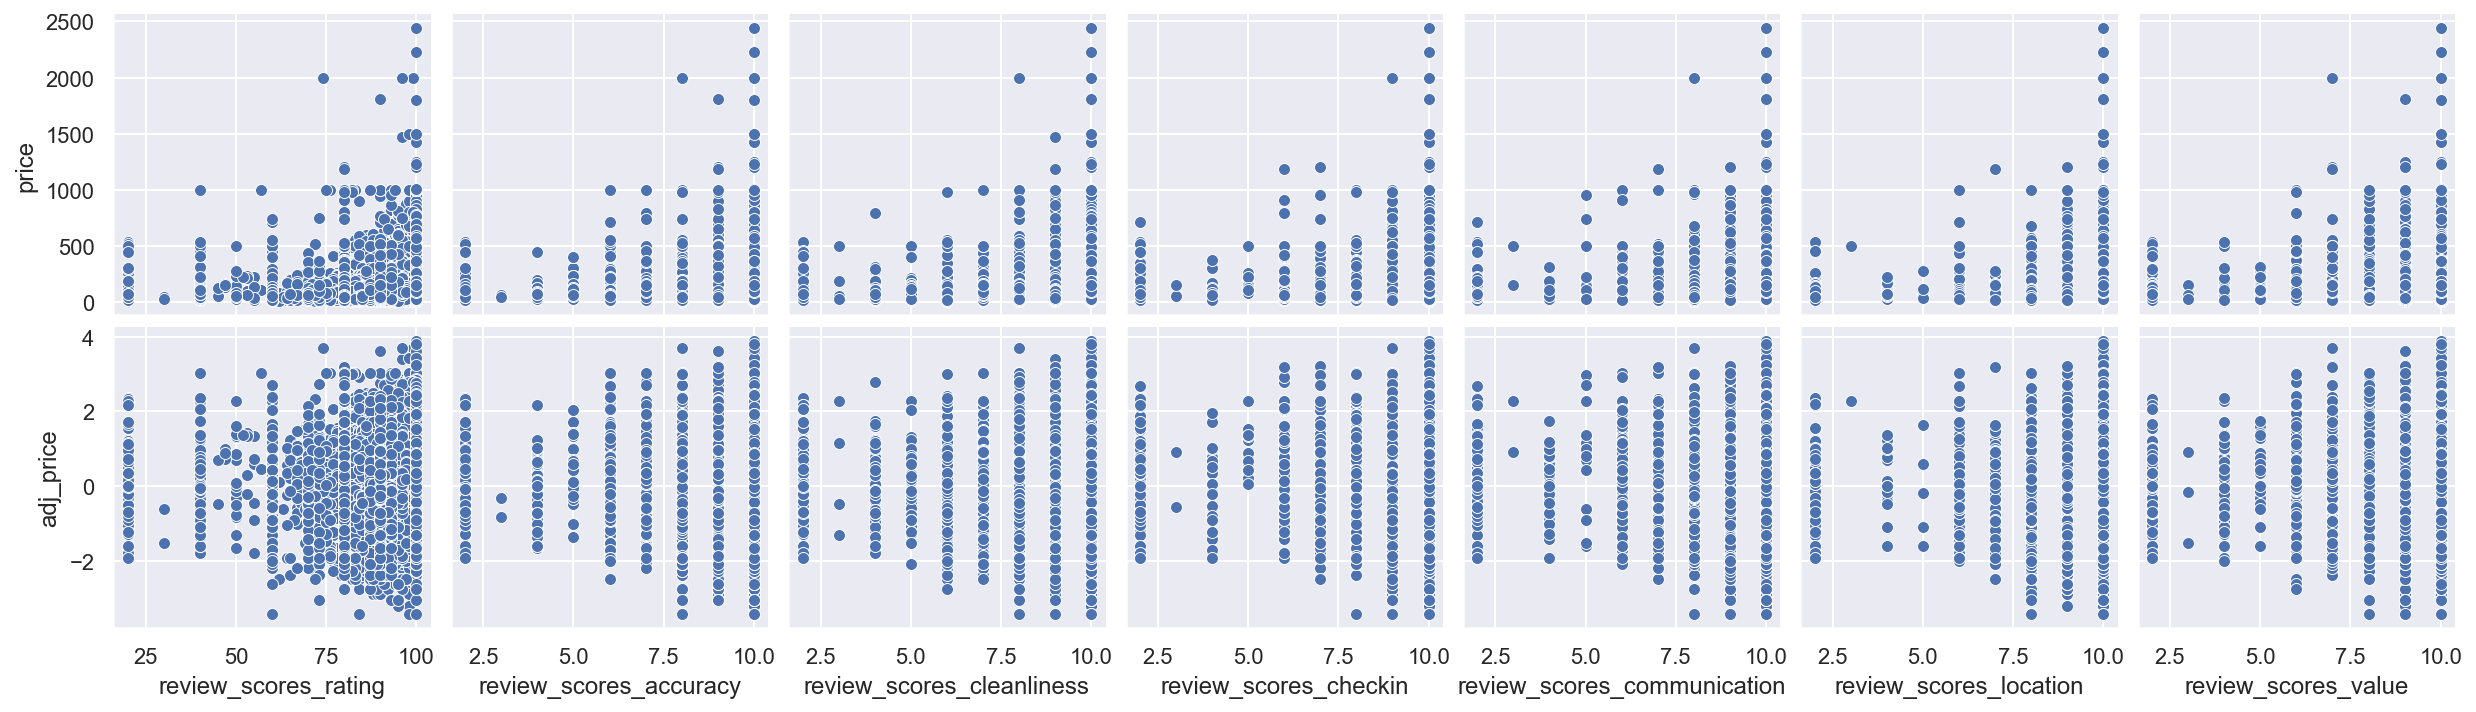

In [18]:
sns.pairplot(data=df_plot, x_vars=['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                                   'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                                   'review_scores_value'], 
             y_vars=['price', 'adj_price'], diag_kind=None);

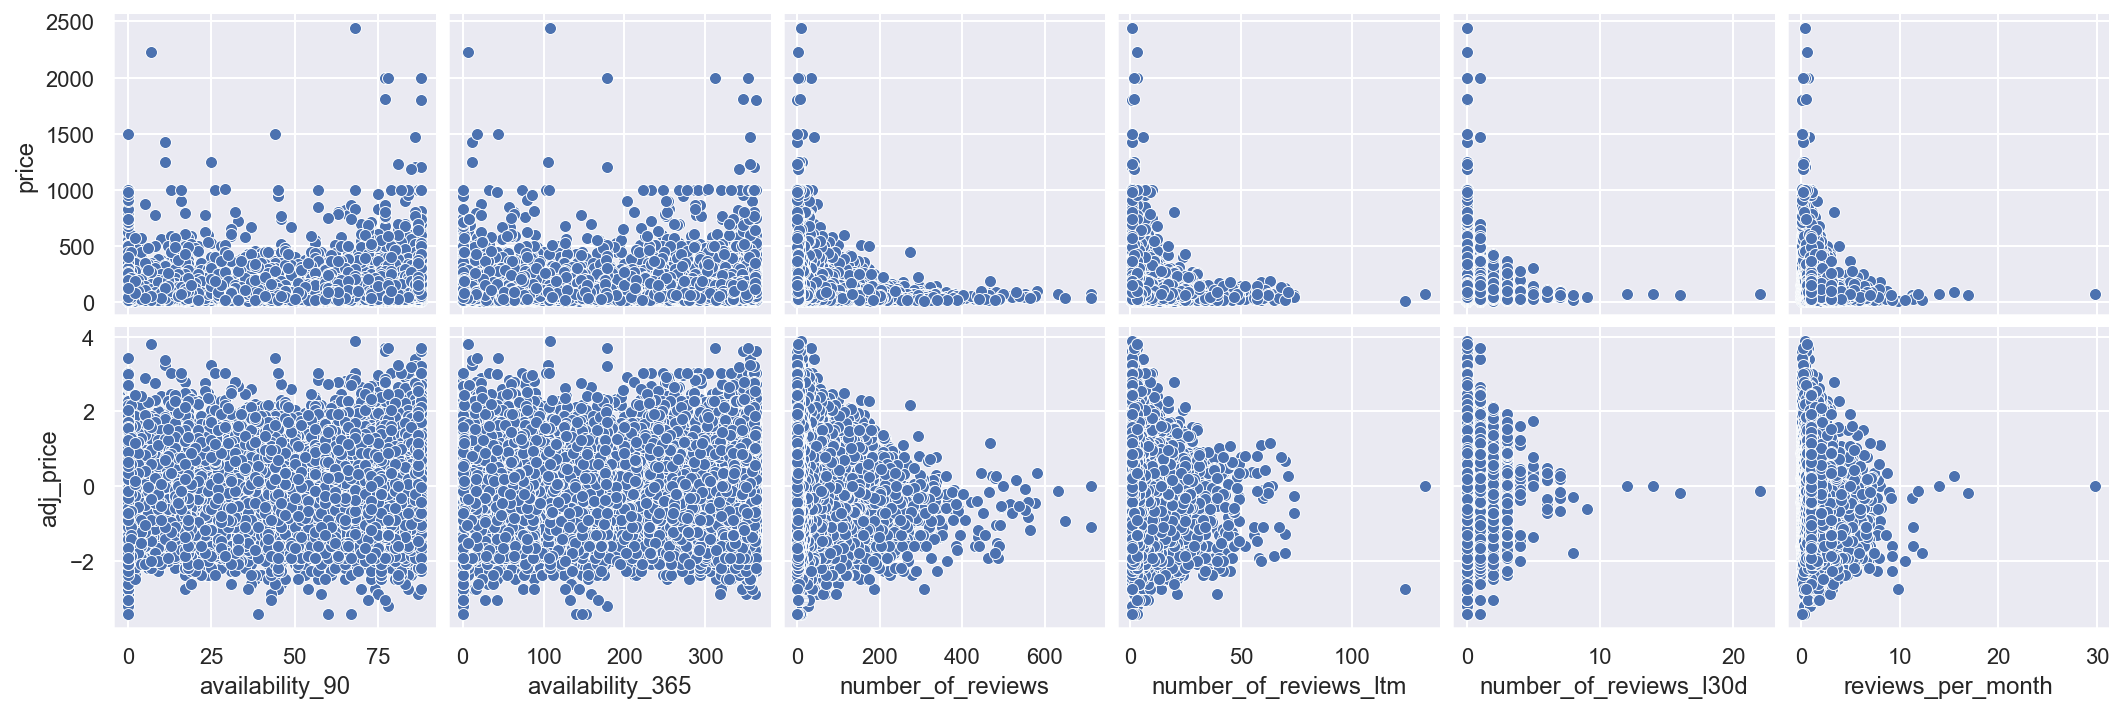

In [19]:
sns.pairplot(data=df_plot, x_vars=['availability_90', 'availability_365', 'number_of_reviews',
                                   'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month'], 
             y_vars=['price', 'adj_price'], diag_kind=None);

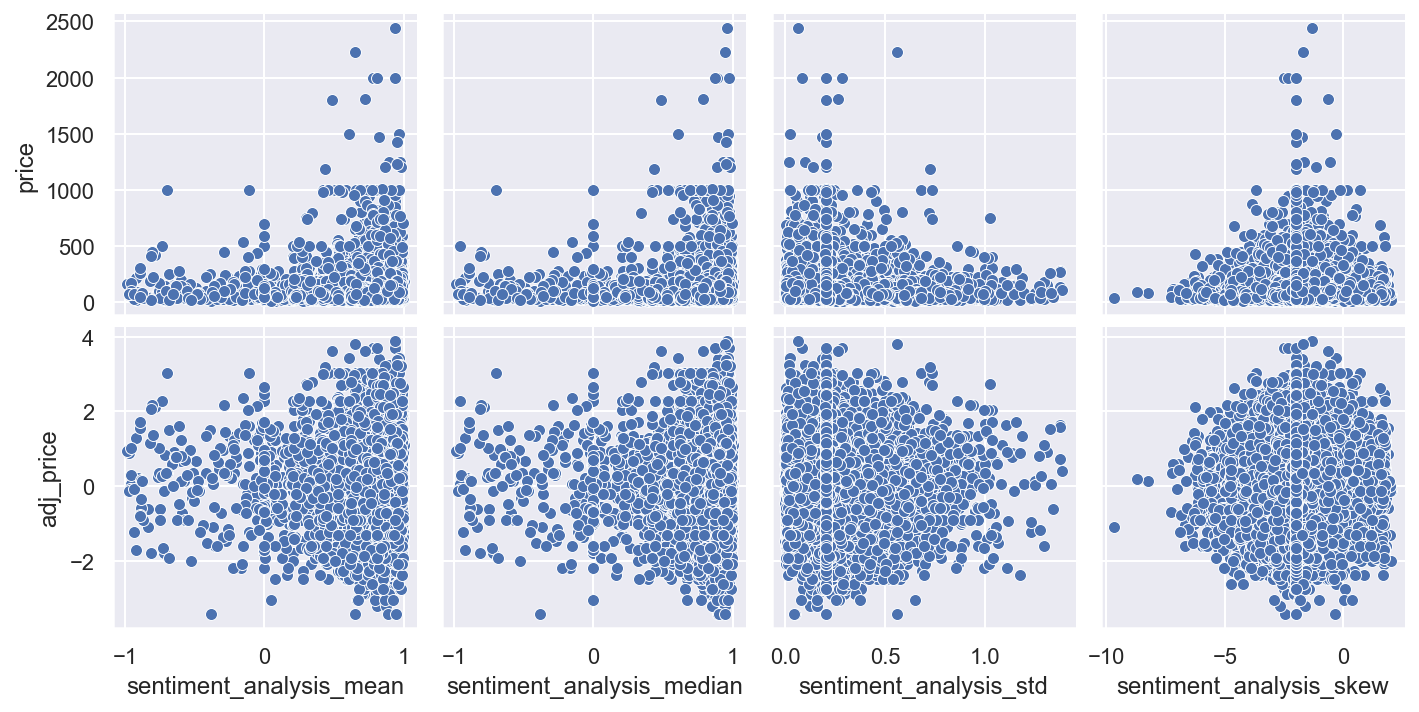

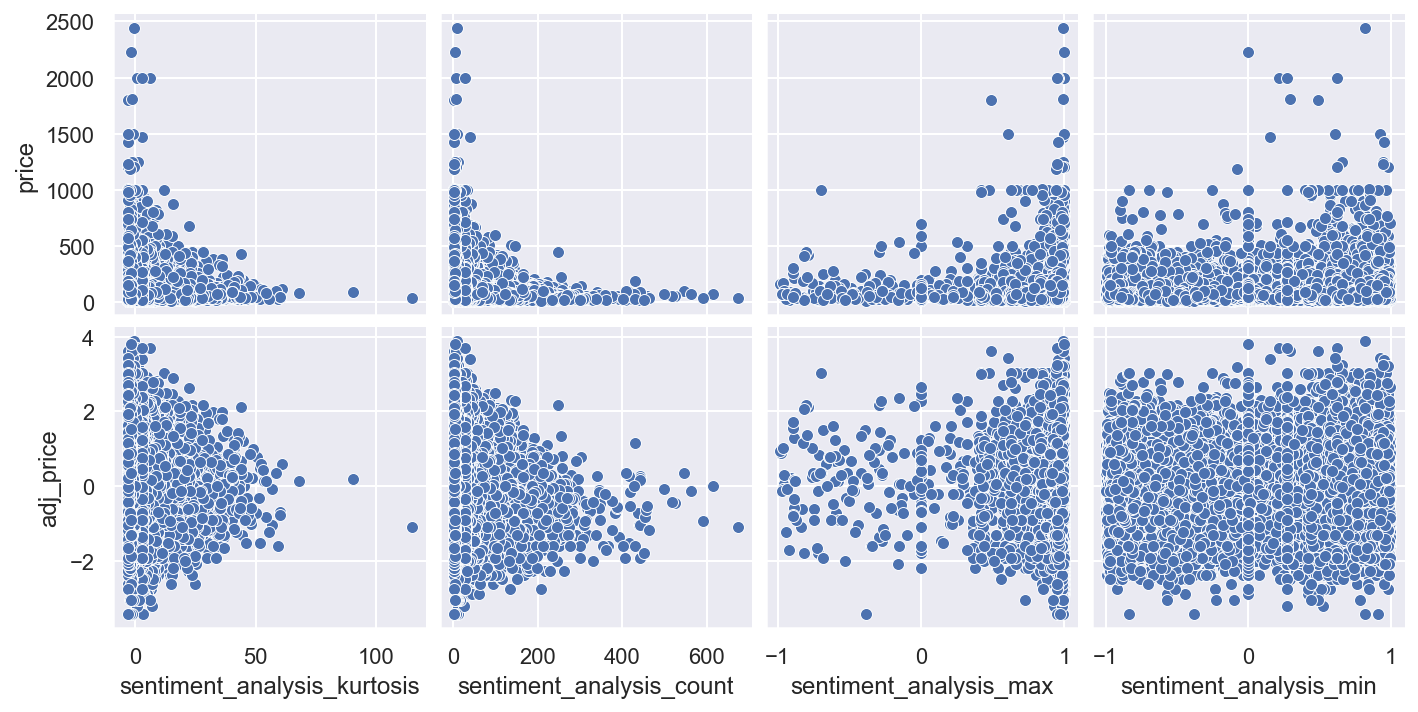

In [20]:
sns.pairplot(data=df_plot, x_vars=['sentiment_analysis_mean', 'sentiment_analysis_median',
                                   'sentiment_analysis_std', 'sentiment_analysis_skew'],
             y_vars=['price', 'adj_price'], diag_kind=None)
sns.pairplot(data=df_plot, x_vars=['sentiment_analysis_kurtosis', 'sentiment_analysis_count',
                                   'sentiment_analysis_max', 'sentiment_analysis_min'],
             y_vars=['price', 'adj_price'], diag_kind=None)
plt.show()

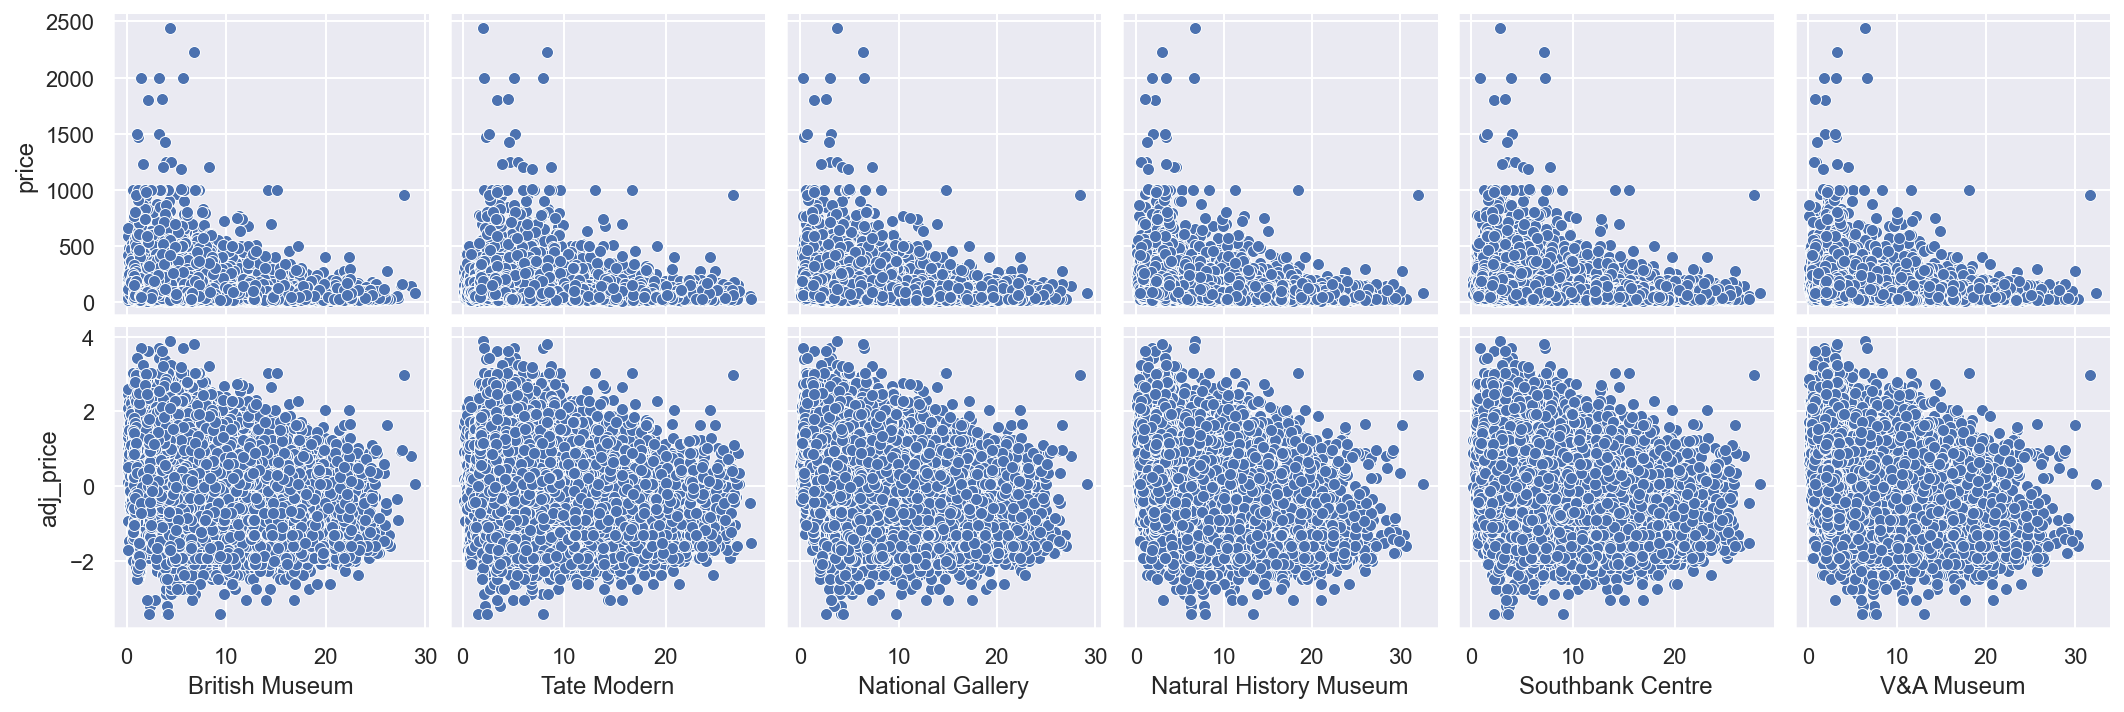

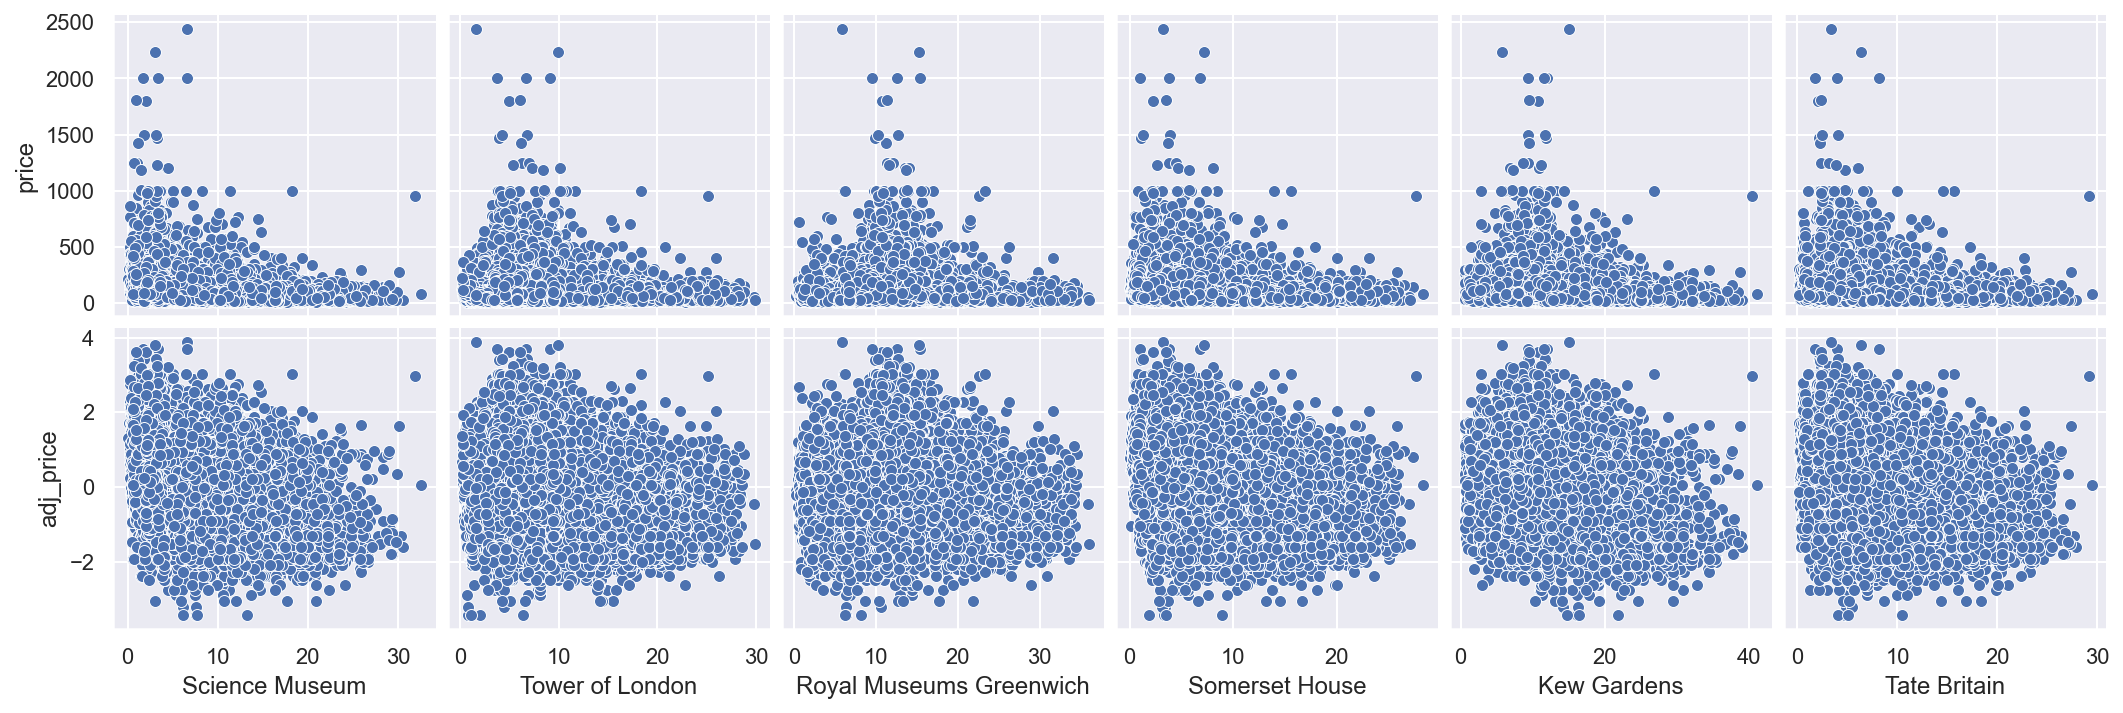

In [21]:
sns.pairplot(data=df_plot, x_vars=['British Museum', 'Tate Modern', 'National Gallery',
                                   'Natural History Museum', 'Southbank Centre', 'V&A Museum'],
             y_vars=['price', 'adj_price'], diag_kind=None)
sns.pairplot(data=df_plot, x_vars=['Science Museum', 'Tower of London', 'Royal Museums Greenwich',
                                   'Somerset House', 'Kew Gardens', 'Tate Britain'],
             y_vars=['price', 'adj_price'], diag_kind=None)
plt.show()

### Days since last review - analysis

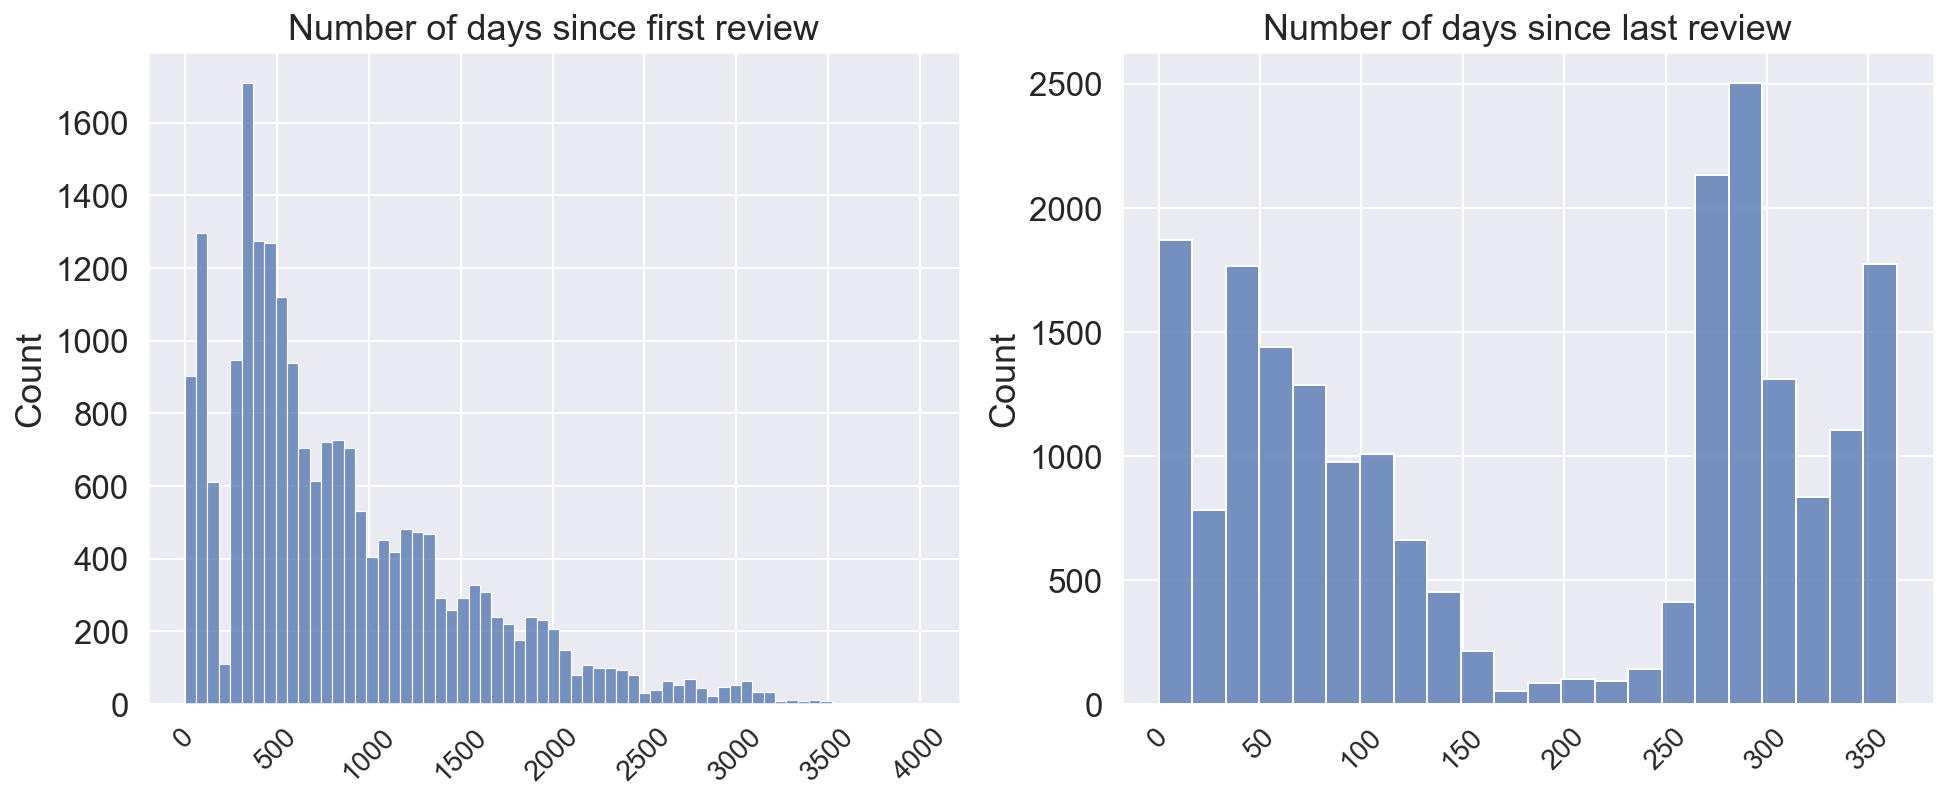

In [22]:
# plot histograms of days since first and last review
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
sns.histplot(df.first_review_days, ax=ax[0])
sns.histplot(df.last_review_days, ax=ax[1])
ax[0].set_title('Number of days since first review')
ax[1].set_title('Number of days since last review')

for a in ax:
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=14, labelrotation=45)

plt.show()

### Analysis of categorical variables

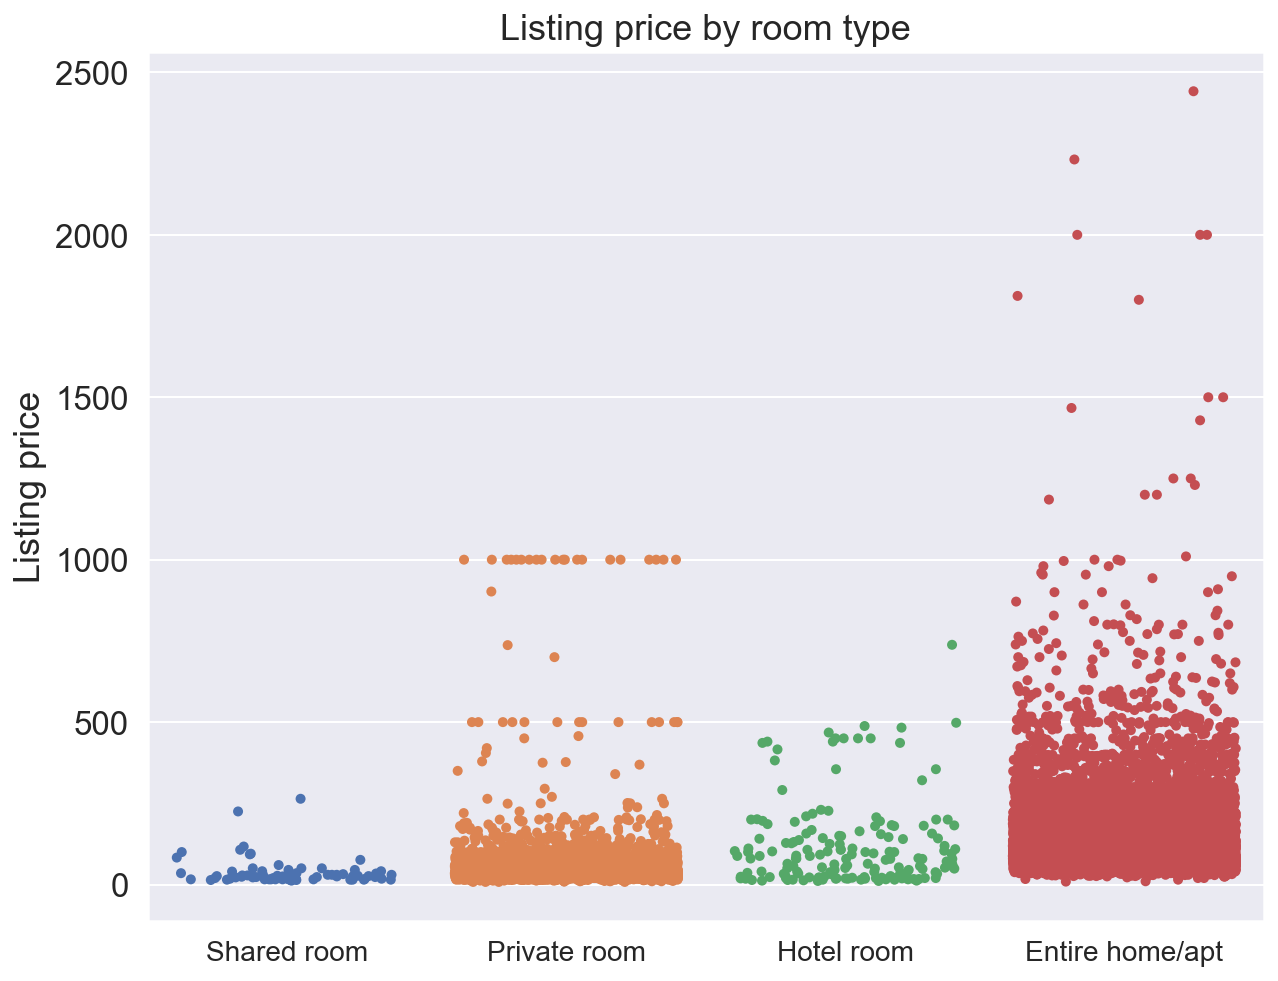

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_order = df_plot.groupby('room_type').price.median().sort_values().index
sns.stripplot(data=df_plot, x='room_type', y='price', order=plot_order, ax=ax, jitter=0.4)

ax.set_title('Listing price by room type')
ax.set_ylabel('Listing price')
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize=14)
    
plt.show()

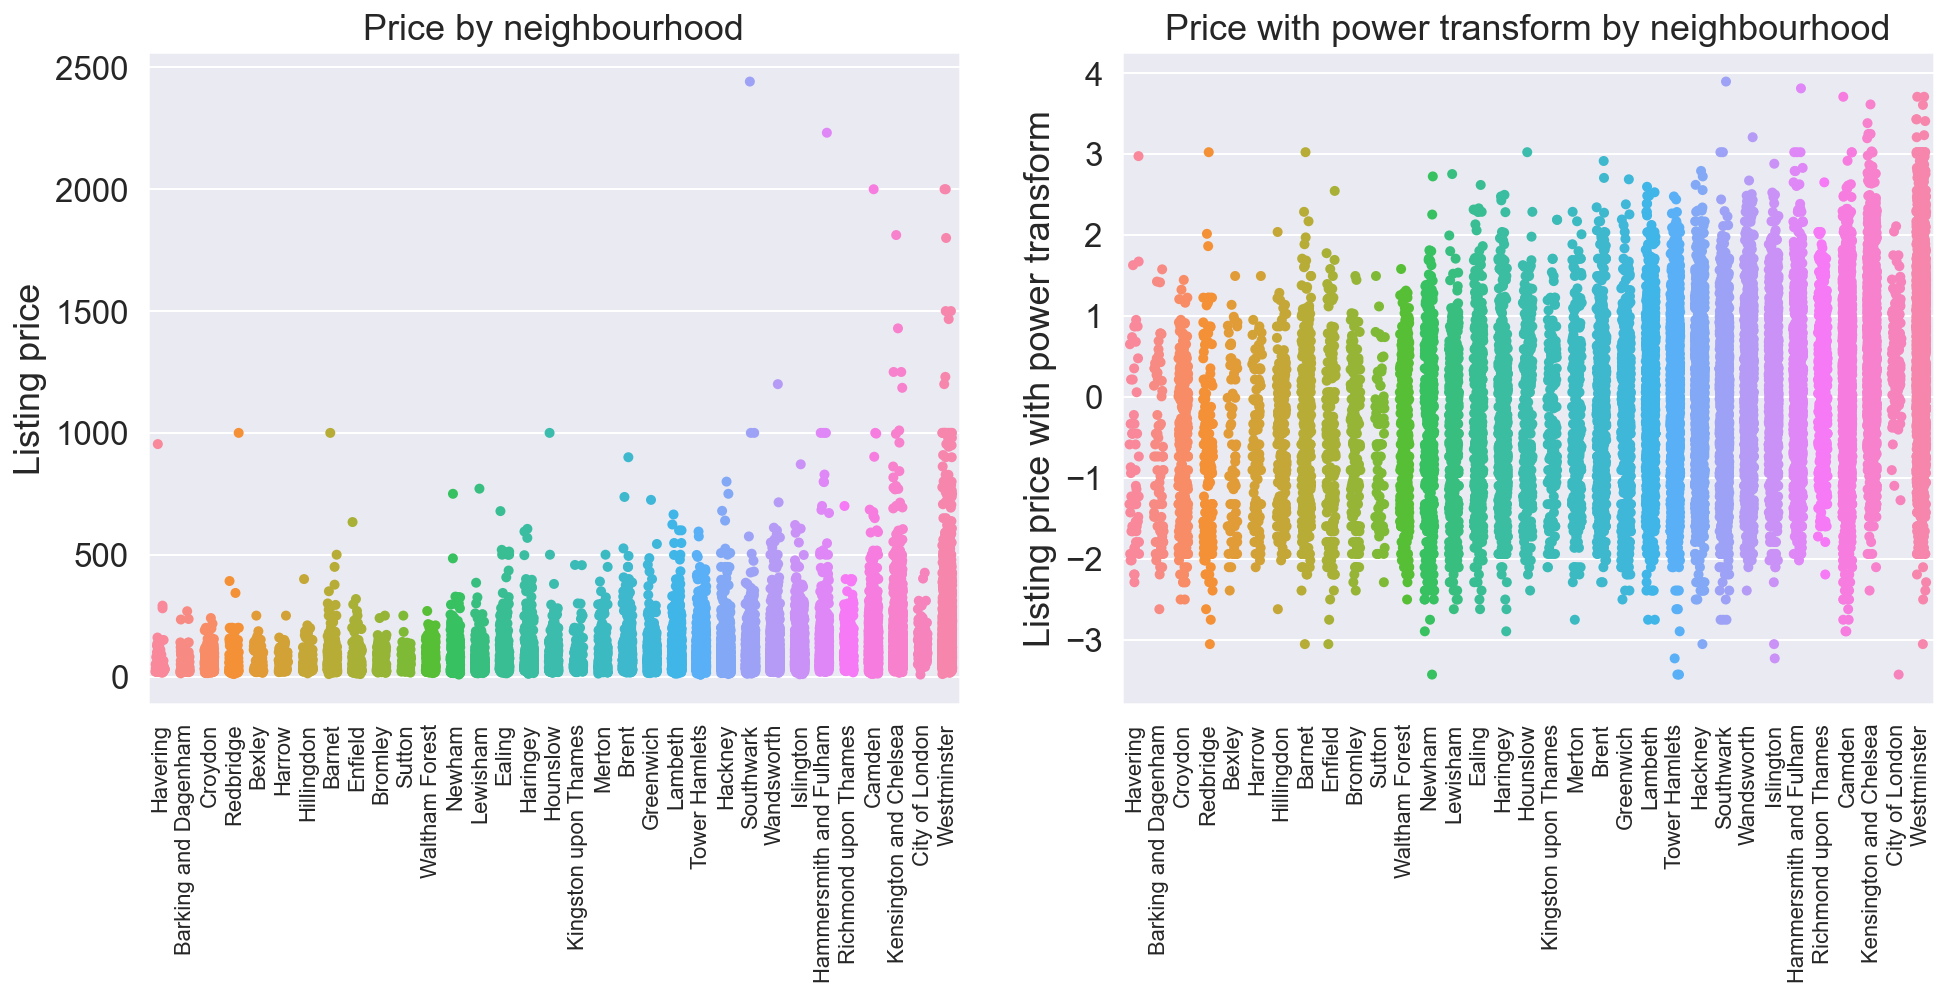

In [25]:
feature = 'neighbourhood_cleansed'
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
plot_order = df_plot.groupby(feature).price.median().sort_values().index
sns.stripplot(data=df_plot, x=feature, y='price', order=plot_order, ax=ax[0], jitter=0.2)
sns.stripplot(data=df_plot, x=feature, y='adj_price', order=plot_order, ax=ax[1], jitter=0.2)

ax[0].set_title('Price by neighbourhood')
ax[1].set_title('Price with power transform by neighbourhood')

ax[0].set_ylabel('Listing price')
ax[1].set_ylabel('Listing price with power transform')

for a in ax:
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=11, labelrotation=90)
    
plt.show()

### Feature engineering using NLP on text data

`amenities`

In [26]:
# use CountVectorizer to inspect the words in the amenities column
cvec = CountVectorizer(token_pattern='(?u)[a-zA-Z][a-z ]+',
                       ngram_range=(1,1),
                       min_df=10)
cmat = cvec.fit_transform(df.amenities)

In [27]:
# look at 10 most frequently occurring words
pd.DataFrame(np.array(cmat.sum(axis=0))[0],
             index=cvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:10]

counts
wifi          20612
heating       20453
essentials    20275
smoke alarm   19469
kitchen       18977
hangers       18553
washer        18281
iron          18139
hair dryer    17386
hot water     16767

In [28]:
# look at 10 least frequently occurring words
pd.DataFrame(np.array(cmat.sum(axis=0))[0],
             index=cvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=True)[:10]

counts
free residential garage on premises       10
standard cable                            10
premium cable                             11
spaces                                    11
clothing storage                          12
hdtv                                      13
free driveway parking on premises         14
drying rack for clothing                  16
wine glasses                              16
tv with netflix                           16

`property_type`

In [29]:
# use CountVectorizer to inspect the words in the property_type column
# use stop_words for information we already have from room_type
property_stop_words = ['private', 'room', 'entire', 'in', 'and', 'shared', 'bed', 'apt', 'guest', 'place']
cvec = CountVectorizer(stop_words=property_stop_words,
                       ngram_range=(1,1))
cmat = cvec.fit_transform(df.property_type)

In [30]:
# look at 10 most frequently occurring words
# this could be useful for modelling
pd.DataFrame(np.array(cmat.sum(axis=0))[0],
             index=cvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:10]

counts
apartment     14430
house          4032
townhouse       827
condominium     591
serviced        304
loft            234
suite           179
hotel           176
guesthouse      107
boutique        106

`name`

In [31]:
df.name.replace(np.nan, '', inplace=True)

In [32]:
# use TfidfVectorizer to inspect the words in the name column
tvec = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,2))
tmat = tvec.fit_transform(df.name)

In [33]:
# look at 10 most frequently occurring words
pd.DataFrame(np.array(tmat.sum(axis=0))[0],
             index=tvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:10]

counts
flat       602.929283
london     567.360164
room       557.801685
bedroom    499.029597
apartment  488.529981
bed        421.712308
double     414.771568
central    333.353834
modern     310.321981
studio     299.689038

`description`

In [34]:
df.description.replace(np.nan, '', inplace=True)

In [35]:
from sklearn.feature_extraction import text
additional_words = ['br']
my_stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

In [36]:
# use TfidfVectorizer to inspect the words in the description column
tvec = TfidfVectorizer(stop_words=my_stop_words,
                       ngram_range=(2,2))
tmat = tvec.fit_transform(df.description)

In [37]:
# look at 10 most frequently occurring words
pd.DataFrame(np.array(tmat.sum(axis=0))[0],
             index=tvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:10]

counts
living room       236.498172
guest access      229.124568
central london    209.373812
fully equipped    173.766522
double bed        168.595485
minutes walk      168.397870
things note       151.491302
minute walk       147.924729
open plan         134.802941
walking distance  133.558748

`neighborhood_overview`    
There are many missing values and most common words are very similar to those in the description (which has fewer missing values). Exclude this from the modelling.

In [38]:
df.neighborhood_overview.replace(np.nan, '', inplace=True)

In [39]:
# use TfidfVectorizer to inspect the words in the name column
tvec = TfidfVectorizer(stop_words=my_stop_words,
                       ngram_range=(2,2))
tmat = tvec.fit_transform(df.neighborhood_overview)

In [41]:
# look at 10 most frequently occurring words
pd.DataFrame(np.array(tmat.sum(axis=0))[0],
             index=tvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:10]

counts
minutes walk      188.478245
minute walk       174.109163
walking distance  154.936713
central london    153.240621
walk away         142.559847
min walk          117.212350
high street       101.115061
bars restaurants   87.933937
hyde park          86.814614
short walk         86.360572

### Write merged data to CSV for modelling

In [61]:
# write data to CSV for modelling
df.to_csv('../GA/capstone-data-airbnb/dec20-data/active_listings_modelling.csv')
df.shape

(20994, 62)